In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from scipy.spatial import distance

# Some helpful functions

In [2]:
"""
This function will fabricate some data. In other words,
it will return a fake dataset of 400 samples that contains
a specified amount of clusters. This function also plots the 
fabricated data.

Parameters:
n_samples - The number of samples in this dataset
n_clusters - The number of actual clusters in this fake dataset
cluster_std - The standard deviation of the clusters. 
seed - The seed to generate from

Returns:
The first list (X) is a list of tuples corresponding to the actual data points, and the
second list (y) corresponds to each data points' cluster/ label.
"""
def fabricate_data(n_clusters, cluster_std, n_samples = 400, seed = 42):
    X, y = make_blobs(n_samples = n_samples, centers = n_clusters, cluster_std = cluster_std, 
                      random_state = seed)
    plt.scatter(X[:, 0], X[:, 1], s = 25)
    plt.show()
    
    return X, y

"""
This function creates a KMeans model using scikit-learn.
It also plots the model's centroids and which points belong to which cluster.

Parameters:
n_clusters - The number of clusters to use for the KMeans model
X - The data points to train from

Returns the KMeans model used.
"""
def KMeans_scikit(n_clusters, X):
    # Create and fit the model
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X)
    predictions = kmeans.predict(X) # Used for labeling the points

    plt.scatter(X[:, 0], X[:, 1], c = predictions, s = 20)
    
    # Plot the centroids
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 100, alpha = 0.9);
    
    plt.title("KMeans Model with {} Clusters".format(n_clusters))
    plt.show()

# Creating the data
For my implementation, I'll create a fake dataset using `scikit-learn` and then model it using the K-Means Clustering Algorithm. This fake dataset will contain 4 very distinct clusters. This particular formation of the dataset is used to display how effective K-Means can be on separable data. Note that the X and Y axis don't mean anything.

Also note that the `y` variable in the code block below contains the labels of each of the data points to classify which cluster they belong to. This won't happen in the real-world if you're using K-Means, but since this is a fake dataset, that's why the labels are there.

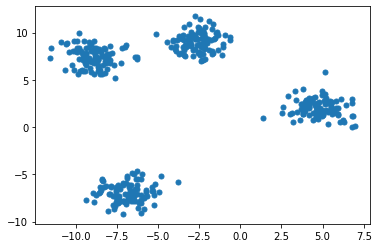

In [3]:
X, y = fabricate_data(4, 1)

## K-Means from Scratch

Recall that the steps for K-Means Clustering are:
1. Randomly initialize K points as the centroids.
2. Calculate each points distance to each of these centroids.
3. Label each point according to the closest centroids. This will make clusters.
4. Calculate the mean data point of each cluster. These will be the new centroids.
5. Repeat steps 2 through 4 until all iterations have been reached or until the centroids don't change by much.

In [4]:
"""
Randomly initializes K centroids as K random data points from the given data.

Parameters:
X - The data to initialize from.
K - The number of centroids to initialize.

Returns K random data points from the given data as a list of lists.
The inner list is the X1, X2 coordinate of the data point.
"""
def random_init(X, K, seed = 5):
    random.seed(seed)
    centroids = random.choices(X, k = K) 
    
    # Convert to an ndarray of lists (this makes it easier to graph later on)
    ## First, convert each list of centroid data points to a normal list
    conv_centroids = [centroid.tolist() for centroid in centroids]
    return np.array(conv_centroids)

"""
Calculates the Euclidean distance from each point in X to the given centroids.

Parameters:
X - The data to calculate the distances for.
centroids - A list of centroids.

Returns a list of lists, where the inner list consists of that respective data point's
distance to each centroid.
"""
def get_distances(X, centroids):
    distances = []
    for x in X:
        distances_to_centroid = []
        for centroid in centroids:
            # Calculate Euclidean distance
            d = distance.euclidean(x, centroid)
            distances_to_centroid.append(d)
        
        distances.append(distances_to_centroid)
    
    return distances

"""
Plots the current centroids and the labelled data points.

Parameters: 
X - The data to plot.
centroids - The centroids to plot.
iteration - The number of iterations the model has gone through.
K - The number of centroids.
"""
def plot_kmeans_iteration(X, labels, centroids, iteration, K):
    plt.scatter(X[:, 0], X[:, 1], c = labels, s = 20)
    
    # Plot the centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', s = 100, alpha = 0.9);
    
    plt.title("KMeans Model with {} Clusters\nAs of {} Iterations".format(K, iteration))
    plt.show()

"""
Labels each data point according to the centroid it is closest to.
The label will simply be the index of the centroid in the list of centroids e.g.
if there are 4 centroids, then points can take on labels 0, 1, 2, or 3.

Parameters:
distances - The distances from each centroid for each data point.

Returns a list the same size of X that is labelled by the index of the centroid it 
is closest to. For example, if for the first data point it's closest to the second centroid,
then the first item in the returned list would be '1' (since we are using a 0-index).
"""
def label_points(distances):
    return np.argmin(distances, axis = 1)

"""
Recalculates the new centroids by calculating the mean of each cluster.

Parameters:
K - The number of clusters.
X - The data.
labels - The labels for each data point, which represents which cluster the point belongs to.

Returns K new centroids as a list of lists.
The inner list is the X1, X2 coordinate of the new centroid.
"""
def compute_centroids(K, X, labels):
    new_centroids = []
    
    # Combine X and labels 
    new_data = np.concatenate((X, labels.reshape(len(X), 1)), axis = 1)
    
    for k in range(0, K):
        # Get the kth cluster i.e. get all points where the label is k
        cluster = np.asarray([x[:2] for x in new_data if x[2] == k])
        if len(cluster) != 0: # Only compute the centroid if a cluster was found.
            # Calculate the new centroid 
            new_centroid = np.mean(cluster, axis = 0)
        new_centroids.append(new_centroid)
    
    return np.asarray(new_centroids)

"""
Let's put everything together for our KMeans algorithm from scratch.

Parameters:
centroids - The initial centroids.
X - The data to cluster.
K - The number of clusters we want to find.
num_iters - The number of iterations for the algorithm.
threshold - The threshold to determine how much centroids have changed.
"""
def KMeans_scratch(centroids, X, K, num_iters, threshold):
    for i in range(0, num_iters):
        # Calculate the distances between each point and each centroid
        distances = get_distances(X, centroids)

        # Label each point
        labels = label_points(distances)

        # Recompute centroids
        new_centroids = compute_centroids(K, X, labels)

        # Check if the centroids changed a lot
        # This means if the Euclidean distance between the two thresholds is less than
        # some threshold, we can stop iterating
        centroids_dists = np.linalg.norm(centroids - new_centroids, axis = 1)
        if all(centroids_dists < threshold):
            plot_kmeans_iteration(X, labels, centroids, i, K)
            break


        # Visualize the clustering for every 5th iteration
        if i % 5 == 0:
            plot_kmeans_iteration(X, labels, centroids, i, K)


        # Reassign new centroids
        centroids = new_centroids

Now that we have all the code we need, let's put everything together! Also, since the 4 clusters are very distinct, let's be smart in how we initialize our centroids. Instead of random initialization, let's instead hard-code them as coordinates within the 4 clusters we see. That way, we'll get better results in the end.

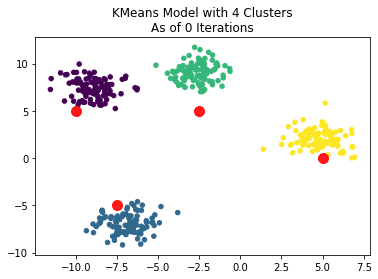

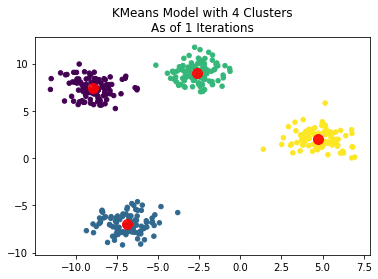

In [5]:
# Initialize our centroids
centroids = np.asarray([
    [-10, 5],
    [-7.5, -5],
    [-2.5, 5],
    [5, 0]
])


num_iters = 100
threshold = 0.1

KMeans_scratch(centroids, X, 4, num_iters, threshold)


## K-Means using Scikit-learn

Now, let's model the same dataset using scikit-learn. Again, we know that there are 4 distinct clusters i.e., 4 distinct classes. 

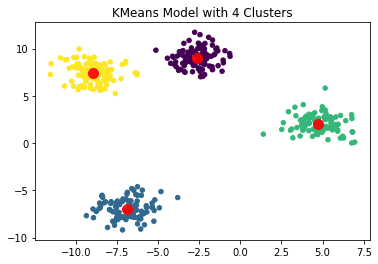

In [6]:
KMeans_scikit(4, X)

# Using a new dataset

I mentioned before that K-Means would perform well if the clusters were distinct. What if they're not? Let's create messier data and see how K-Means performs on them. This time, I'll randomize the number of actual clusters between 2 and 10. That way, it'll be a lot more difficult to determine K.

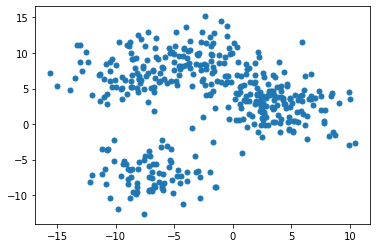

In [7]:
np.random.seed(5)
n_clusters = np.random.randint(2, 11)
X2, y2 = fabricate_data(n_clusters, 2.5)

## K-Means from Scratch

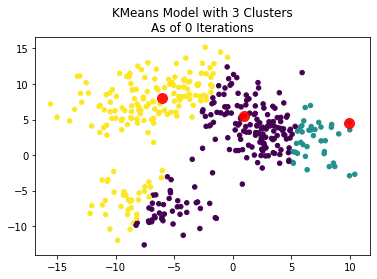

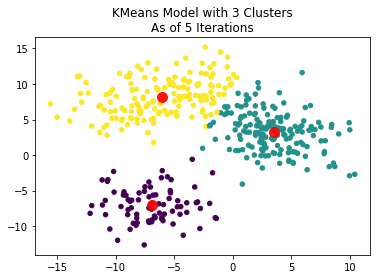

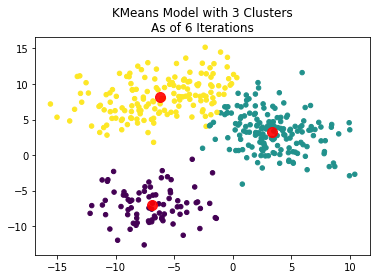

In [8]:
# Initialize our centroids
centroids = random_init(X2, 3)

KMeans_scratch(centroids, X2, 3, num_iters, threshold)

## K-Means using Scikit-learn

Now, let's model the same dataset using scikit-learn. Again, we'll use K = 3.

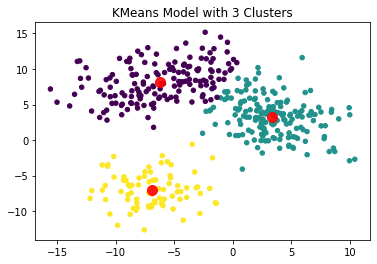

In [9]:
KMeans_scikit(3, X2)

# Finding Optimal K using Elbow Method

Let's also try implementing the Elbow Method and seeing what the optimal value of K would be.

Recall that in order to use the Elbow Method, we have to calculate the Within-Cluster Sum of Squared Errors $WSS$. This is done by calculating the squared error between each data point and it's respective centroid and then adding all of these squared errors together.

Luckily, this is already handled by scikit-learn's KMeans model. The KMeans model has a field called `inertia` which corresponds to the $WSS$. More specifically, a KMeans model's inertia is the sum of squared distances of samples to their closest cluster center.

In [10]:
K_list = np.arange(2, 11)
WSS_list = []

# Iterate through each possible value of K 
for k in K_list:
    # Create a KMeans model of specified K
    model = KMeans(n_clusters = k)
    
    # Fit it to the data
    model.fit(X2)
    
    # Calculate inertias (WSS's) and append them to list
    WSS_list.append(model.inertia_)

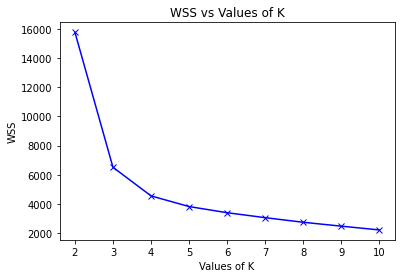

In [11]:
plt.plot(K_list, WSS_list, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('WSS') 
plt.title('WSS vs Values of K') 
plt.show() 

Using this plot, we can determine which value of K would be the best to use for our final model. According to the Elbow Method, we choose the K at the "elbow", or the point at which the WSS starts decreasing in a linear fashion. So, the optimal value of K would be at either 4 or 5. For me, I'll say 5 because there is a much more distinct linear decrease in the values of K afterwards i.e., there is still a steep decline in WSS between 4 and 5. But, you can argue otherwise.

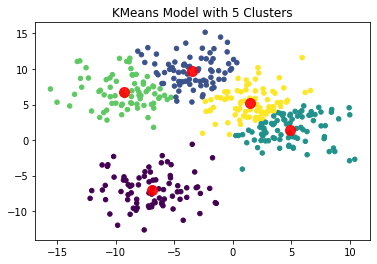

In [12]:
KMeans_scikit(5, X2)

# Changing K

Recall that when we were using the Elbow Method, we used different types of K. Let's visualize how the clustering looks like with the different values of K.

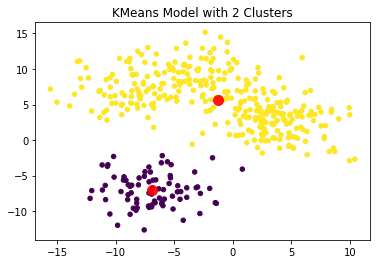

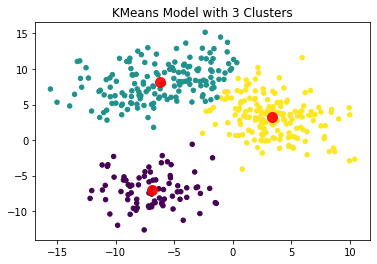

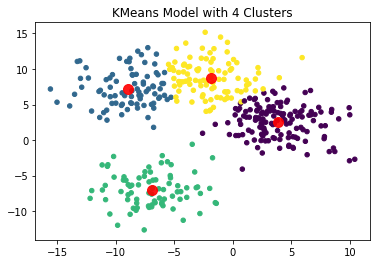

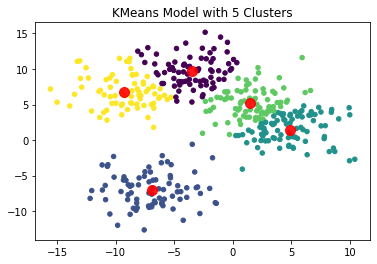

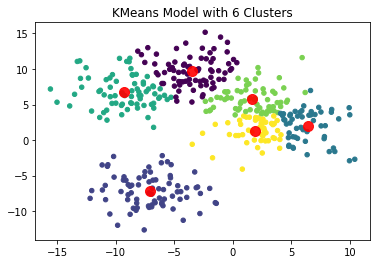

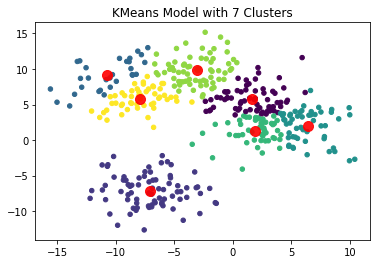

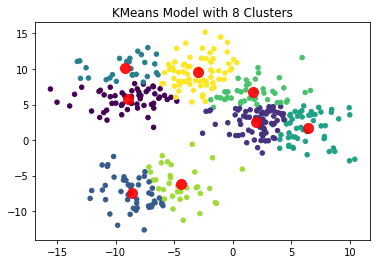

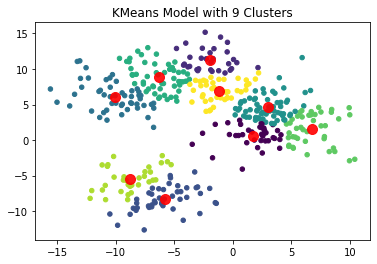

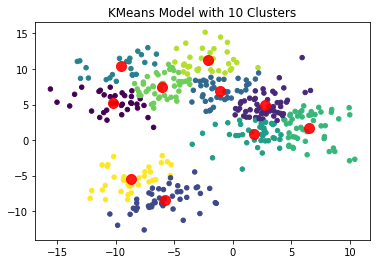

In [13]:
for k in np.arange(2, 11):
    # Create a KMeans model of specified K and plot it
    KMeans_scikit(k, X2)